<a href="https://colab.research.google.com/github/sidc124/Alzhimer-Detection/blob/main/_set_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's vs. Dementia EEG Classification — End-to-End Deep Learning Pipeline

This notebook implements the full pipeline you described:
1) **Find common channels** across OpenNeuro datasets and align them  
2) **Preprocess** (filtering, referencing, resampling)  
3) **Segment** signals into fixed-size windows and **standardize shapes** (pad/crop)  
4) **Build datasets** and loaders for train/val/test (subject-wise splits)  
5) **Train baselines** (EEGNet) and a **custom hybrid model** that aims to outperform EEGNet  
6) **Evaluate & cross-test** across datasets (train on one, test on the other)  
7) **Result analysis** with metrics and confusion matrices

## 1. Setup & Config

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/EEG_Project/dataset_2/sub-hc1/ses-hc/eeg"
import glob
import os

# Base directory in Google Drive
base_path = "/content/drive/MyDrive/EEG_Project"

# Find all .set files (ignore .bdf)
set_files = glob.glob(os.path.join(base_path, "**", "*.set"), recursive=True)

print(f"Found {len(set_files)} .set files")

# Check a few results
print("Example .set file:", set_files[0] if set_files else "None found")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
sub-hc1_ses-hc_task-rest_channels.tsv  sub-hc1_ses-hc_task-rest_eeg.json
sub-hc1_ses-hc_task-rest_eeg.bdf       sub-hc1_ses-hc_task-rest_events.tsv
Found 88 .set files
Example .set file: /content/drive/MyDrive/EEG_Project/dataset_1/sub-005/eeg/sub-005_task-eyesclosed_eeg.set


## 2. Channels finding and common channels

In [3]:
!pip install mne
import mne

# Pick one file from the .set dataset
sample_set_file = set_files[0]

# Load raw data without preprocessing
raw_set = mne.io.read_raw_eeglab(sample_set_file, preload=False)

# Get channel names
channels_set = raw_set.info["ch_names"]

print("Channels in .set dataset:", channels_set)


/tmp/ipython-input-778039522.py:8: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_set = mne.io.read_raw_eeglab(sample_set_file, preload=False)


Channels in .set dataset: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']


## 3. reordering the dataset


In [4]:
import mne

# Define common_channels as all channels in the .set dataset (no .bdf dataset here)
common_channels = channels_set

# We will use the order from the .set dataset but only keep channels present in common_channels
ordered_common_channels = [ch for ch in channels_set if ch in common_channels]

print("Final channel order:", ordered_common_channels)

# Function to load and reorder channels
def load_and_reorder(filepath, filetype, channel_order):
    if filetype == "set":
        raw = mne.io.read_raw_eeglab(filepath, preload=True)
    else:
        raise ValueError("Unsupported file type")

    # Pick only common channels and reorder
    raw.pick_channels(channel_order)
    raw.reorder_channels(channel_order)

    return raw

# Load all .set files in the same channel order
all_set_data = [load_and_reorder(f, "set", ordered_common_channels) for f in set_files]

# No .bdf loading or processing in this version


Final channel order: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-839818290.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


## 4. checking if the order is same or not


In [ ]:
# Check first 3 files from each dataset to verify channel order
for i, raw_obj in enumerate(all_set_data[:3]):
    print(f"\nSET file {i+1} channels:")
    print(raw_obj.info["ch_names"])

for i, raw_obj in enumerate(all_bdf_data[:3]):
    print(f"\nBDF file {i+1} channels:")
    print(raw_obj.info["ch_names"])

# Final check: compare channel order between first SET and first BDF
set_order = all_set_data[0].info["ch_names"]
bdf_order = all_bdf_data[0].info["ch_names"]

if set_order == bdf_order:
    print("\n✅ Channel orders match for SET and BDF datasets.")
else:
    print("\n❌ Channel orders do NOT match.")
    print("SET order:", set_order)
    print("BDF order:", bdf_order)



SET file 1 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 2 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 3 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

BDF file 1 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

BDF file 2 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

BDF file 3 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

✅ Channel orders match for SET and BDF datasets.


##5. checking the sampling freuquency

## 6. Resampling

In [5]:
target_sfreq = 128  # Hz

# Resample .set files
for i, raw in enumerate(all_set_data):
    if raw.info['sfreq'] != target_sfreq:
        raw.resample(target_sfreq)
        print(f"Resampled .set file {i+1} to {target_sfreq} Hz")




Resampled .set file 1 to 128 Hz
Resampled .set file 2 to 128 Hz
Resampled .set file 3 to 128 Hz
Resampled .set file 4 to 128 Hz
Resampled .set file 5 to 128 Hz
Resampled .set file 6 to 128 Hz
Resampled .set file 7 to 128 Hz
Resampled .set file 8 to 128 Hz
Resampled .set file 9 to 128 Hz
Resampled .set file 10 to 128 Hz
Resampled .set file 11 to 128 Hz
Resampled .set file 12 to 128 Hz
Resampled .set file 13 to 128 Hz
Resampled .set file 14 to 128 Hz
Resampled .set file 15 to 128 Hz
Resampled .set file 16 to 128 Hz
Resampled .set file 17 to 128 Hz
Resampled .set file 18 to 128 Hz
Resampled .set file 19 to 128 Hz
Resampled .set file 20 to 128 Hz
Resampled .set file 21 to 128 Hz
Resampled .set file 22 to 128 Hz
Resampled .set file 23 to 128 Hz
Resampled .set file 24 to 128 Hz
Resampled .set file 25 to 128 Hz
Resampled .set file 26 to 128 Hz
Resampled .set file 27 to 128 Hz
Resampled .set file 28 to 128 Hz
Resampled .set file 29 to 128 Hz
Resampled .set file 30 to 128 Hz
Resampled .set file

##6. normalization


In [6]:
import numpy as np

# ===== 1️⃣ Shortest recording length =====
min_times = min([raw.n_times for raw in all_set_data])
print(f"Minimum common length (time points): {min_times}")

# ===== 2️⃣ Combine dataset =====
X_all = []

for raw in all_set_data:
    X_all.append(raw.get_data()[:, :min_times])

X_all = np.array(X_all)  # (n_samples, n_channels, n_times)
print(f"✅ Dataset shape (raw): {X_all.shape}")

# ===== 3️⃣ Normalize per sample, per channel =====
X_scaled = np.zeros_like(X_all, dtype=np.float32)

for i in range(X_all.shape[0]):           # loop over samples
    for ch in range(X_all.shape[1]):      # loop over channels
        ch_data = X_all[i, ch, :]
        mean = np.mean(ch_data)
        std = np.std(ch_data)
        if std > 0:   # avoid divide by zero
            X_scaled[i, ch, :] = (ch_data - mean) / std
        else:
            X_scaled[i, ch, :] = ch_data - mean  # flat channel

print(f"✅ Normalized dataset shape: {X_scaled.shape}")

# ===== 4️⃣ Save ONLY normalized dataset =====
np.save("X_normalized.npy", X_scaled)
np.save('/content/drive/MyDrive/X_normalized.npy', X_scaled)

print("💾 Saved normalized dataset as 'X_normalized.npy' (local + Google Drive)")


Minimum common length (time points): 39181
✅ Dataset shape (raw): (88, 19, 39181)
✅ Normalized dataset shape: (88, 19, 39181)
💾 Saved normalized dataset as 'X_normalized.npy' (local + Google Drive)


In [7]:
import numpy as np

# Load normalized data
X_normalized = np.load('/content/drive/MyDrive/X_normalized.npy')

print("✅ X_normalized loaded")
print("Shape:", X_normalized.shape)   # (n_samples, n_channels, n_times)
print("Data type:", X_normalized.dtype)

# Check overall statistics
print("\n=== Statistics ===")
print("Min:", np.min(X_normalized))
print("Max:", np.max(X_normalized))
print("Mean:", np.mean(X_normalized))
print("Std Dev:", np.std(X_normalized))

# Check one sample (first recording)
sample_idx = 0
print(f"\n=== Sample {sample_idx} details ===")
print("Shape:", X_normalized[sample_idx].shape)
print("Mean:", np.mean(X_normalized[sample_idx]))
print("Std Dev:", np.std(X_normalized[sample_idx]))

# Check across channels for the first sample
print("\n=== First sample channel-wise stats ===")
for ch in range(min(5, X_normalized.shape[1])):  # show first 5 channels
    ch_data = X_normalized[sample_idx, ch, :]
    print(f"Channel {ch}: mean={np.mean(ch_data):.4f}, std={np.std(ch_data):.4f}")


✅ X_normalized loaded
Shape: (88, 19, 39181)
Data type: float32

=== Statistics ===
Min: -26.68645
Max: 19.260849
Mean: -1.5955076e-11
Std Dev: 1.0000004

=== Sample 0 details ===
Shape: (19, 39181)
Mean: -1.947218e-10
Std Dev: 0.99999994

=== First sample channel-wise stats ===
Channel 0: mean=0.0000, std=1.0000
Channel 1: mean=0.0000, std=1.0000
Channel 2: mean=0.0000, std=1.0000
Channel 3: mean=0.0000, std=1.0000
Channel 4: mean=-0.0000, std=1.0000


In [8]:
import numpy as np

# Load the .npy file
data = np.load('/content/drive/MyDrive/X_normalized.npy')

# Now you can inspect the 'data' variable
# For example, to see its shape:
print(data.shape)

# To see its data type:
print(data.dtype)

(88, 19, 39181)
float32


## 9. Save Metrics & Plots

In [9]:
for i, sample in enumerate(X_all):
    print(f"Sample {i+1} shape: {sample.shape}")


Sample 1 shape: (19, 39181)
Sample 2 shape: (19, 39181)
Sample 3 shape: (19, 39181)
Sample 4 shape: (19, 39181)
Sample 5 shape: (19, 39181)
Sample 6 shape: (19, 39181)
Sample 7 shape: (19, 39181)
Sample 8 shape: (19, 39181)
Sample 9 shape: (19, 39181)
Sample 10 shape: (19, 39181)
Sample 11 shape: (19, 39181)
Sample 12 shape: (19, 39181)
Sample 13 shape: (19, 39181)
Sample 14 shape: (19, 39181)
Sample 15 shape: (19, 39181)
Sample 16 shape: (19, 39181)
Sample 17 shape: (19, 39181)
Sample 18 shape: (19, 39181)
Sample 19 shape: (19, 39181)
Sample 20 shape: (19, 39181)
Sample 21 shape: (19, 39181)
Sample 22 shape: (19, 39181)
Sample 23 shape: (19, 39181)
Sample 24 shape: (19, 39181)
Sample 25 shape: (19, 39181)
Sample 26 shape: (19, 39181)
Sample 27 shape: (19, 39181)
Sample 28 shape: (19, 39181)
Sample 29 shape: (19, 39181)
Sample 30 shape: (19, 39181)
Sample 31 shape: (19, 39181)
Sample 32 shape: (19, 39181)
Sample 33 shape: (19, 39181)
Sample 34 shape: (19, 39181)
Sample 35 shape: (19, 3

In [10]:
import numpy as np
import pandas as pd
from pathlib import Path

# ===== 1️⃣ Load participant metadata (only for .set dataset) =====
df_set = pd.read_csv("/content/drive/MyDrive/EEG_Project/participants_set.tsv", sep="\t")

# Map groups to labels (patients=1, controls=0)
group_map_set = {'A': 1, 'F': 1, 'C': 0}
df_set["label"] = df_set["Group"].map(group_map_set)

print("=== SET Metadata ===")
print(df_set.head())

# ===== 2️⃣ Load normalized data =====
X_normalized = np.load('/content/drive/MyDrive/X_normalized.npy')
print("✅ Loaded normalized dataset:", X_normalized.shape)

# ===== 3️⃣ Match participant IDs with labels (only for .set data) =====
ids_set = [Path(raw.filenames[0]).parts[-3] for raw in all_set_data]

missing_set = [sid for sid in ids_set if sid not in df_set["participant_id"].values]
print("Missing from SET metadata:", missing_set)

# ===== 4️⃣ Build labels array (from .set only) =====
y_all = []
id_all = []

for raw in all_set_data:
    sid = Path(raw.filenames[0]).parts[-3]
    label = df_set.loc[df_set["participant_id"] == sid, "label"].values[0]
    y_all.append(label)
    id_all.append(sid)

y_all = np.array(y_all)
id_all = np.array(id_all)

print("✅ Labels shape:", y_all.shape)
print("Class distribution:\n", pd.Series(y_all).value_counts())

# ===== 5️⃣ Save labeled normalized dataset =====
np.save("X_normalized.npy", X_normalized)   # keep normalized data
np.save("y_all.npy", y_all)
np.save('/content/drive/MyDrive/X_normalized.npy', X_normalized)
np.save('/content/drive/MyDrive/y_all.npy', y_all)

pd.DataFrame({"ID": id_all, "label": y_all}).to_csv("id_labels.csv", index=False)

print("💾 Saved normalized X as 'X_normalized.npy', labels as 'y_all.npy', and ID-label mapping")


=== SET Metadata ===
  participant_id Gender  Age Group  MMSE  label
0        sub-001      F   57     A    16      1
1        sub-002      F   78     A    22      1
2        sub-003      M   70     A    14      1
3        sub-004      F   67     A    20      1
4        sub-005      M   70     A    22      1
✅ Loaded normalized dataset: (88, 19, 39181)
Missing from SET metadata: []
✅ Labels shape: (88,)
Class distribution:
 1    59
0    29
Name: count, dtype: int64
💾 Saved normalized X as 'X_normalized.npy', labels as 'y_all.npy', and ID-label mapping


In [11]:
import pandas as pd


df_overview = pd.DataFrame({
    "ID": id_all,
    "Label": y_all
})


label_map = {0: "Healthy", 1: "Alzheimer/Dementia/PD"}
df_overview["Label_Name"] = df_overview["Label"].map(label_map)


print(df_overview)


df_overview.to_csv("/content/drive/MyDrive/dataset_overview.csv", index=False)
print("💾 Saved to /content/drive/MyDrive/dataset_overview.csv")

print("\nClass distribution:")
print(df_overview["Label_Name"].value_counts())


         ID  Label             Label_Name
0   sub-005      1  Alzheimer/Dementia/PD
1   sub-003      1  Alzheimer/Dementia/PD
2   sub-001      1  Alzheimer/Dementia/PD
3   sub-006      1  Alzheimer/Dementia/PD
4   sub-004      1  Alzheimer/Dementia/PD
..      ...    ...                    ...
83  sub-084      1  Alzheimer/Dementia/PD
84  sub-085      1  Alzheimer/Dementia/PD
85  sub-086      1  Alzheimer/Dementia/PD
86  sub-087      1  Alzheimer/Dementia/PD
87  sub-088      1  Alzheimer/Dementia/PD

[88 rows x 3 columns]
💾 Saved to /content/drive/MyDrive/dataset_overview.csv

Class distribution:
Label_Name
Alzheimer/Dementia/PD    59
Healthy                  29
Name: count, dtype: int64


In [ ]:
for i, arr in enumerate(X_all):
    print(f"Index {i}: shape = {np.array(arr).shape}")


Index 0: shape = (15, 23168)
Index 1: shape = (15, 23168)
Index 2: shape = (15, 23168)
Index 3: shape = (15, 23168)
Index 4: shape = (15, 23168)
Index 5: shape = (15, 23168)
Index 6: shape = (15, 23168)
Index 7: shape = (15, 23168)
Index 8: shape = (15, 23168)
Index 9: shape = (15, 23168)
Index 10: shape = (15, 23168)
Index 11: shape = (15, 23168)
Index 12: shape = (15, 23168)
Index 13: shape = (15, 23168)
Index 14: shape = (15, 23168)
Index 15: shape = (15, 23168)
Index 16: shape = (15, 23168)
Index 17: shape = (15, 23168)
Index 18: shape = (15, 23168)
Index 19: shape = (15, 23168)
Index 20: shape = (15, 23168)
Index 21: shape = (15, 23168)
Index 22: shape = (15, 23168)
Index 23: shape = (15, 23168)
Index 24: shape = (15, 23168)
Index 25: shape = (15, 23168)
Index 26: shape = (15, 23168)
Index 27: shape = (15, 23168)
Index 28: shape = (15, 23168)
Index 29: shape = (15, 23168)
Index 30: shape = (15, 23168)
Index 31: shape = (15, 23168)
Index 32: shape = (15, 23168)
Index 33: shape = (1

In [12]:
import os
import time
import os, time, glob
import numpy as np
import pandas as pd
import librosa as lb
from tqdm import tqdm
import seaborn as sns
from scipy.io import loadmat
from scipy.signal.windows import gaussian
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from keras.regularizers import l2
from tensorflow.random import set_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, AvgPool2D
from keras import Model, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

# ===== 1️⃣ Load normalized data + labels =====
X = np.load("/content/drive/MyDrive/X_normalized.npy")   # (N, 15, 23168)
y = np.load("/content/drive/MyDrive/y_all.npy")          # (N,)

print("✅ Data loaded")
print("X:", X.shape, "y:", y.shape)

# ===== 2️⃣ Split into train (60%) and temp (40%) =====
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# ===== 3️⃣ Split temp into val (20%) and test (20%) =====
# Note: test_size=0.5 → 0.5 * 0.40 = 0.20 overall
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("✅ Final splits:")
print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

# ===== 4️⃣ Check class balance =====
print("\nClass distribution:")
print("Train:", pd.Series(y_train).value_counts().to_dict())
print("Val  :", pd.Series(y_val).value_counts().to_dict())
print("Test :", pd.Series(y_test).value_counts().to_dict())


✅ Data loaded
X: (88, 19, 39181) y: (88,)
✅ Final splits:
Train: (52, 19, 39181) (52,)
Val  : (18, 19, 39181) (18,)
Test : (18, 19, 39181) (18,)

Class distribution:
Train: {1: 35, 0: 17}
Val  : {1: 12, 0: 6}
Test : {1: 12, 0: 6}


In [14]:
import torch
import torch.nn as nn

# Depthwise Separable Conv1d Block
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dropout=0.3):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size,
            stride=stride, padding=padding, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = torch.tanh(x)
        return self.dropout(x)


class STEADYNet1D(nn.Module):
    def __init__(self, num_classes=2, dropout=0.3):
        super(STEADYNet1D, self).__init__()

        # Input: (B, 15, 23168)
        self.conv1 = nn.Conv1d(19, 32, kernel_size=7, stride=2, padding=3)
        self.bn1   = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)
        self.bn2   = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3   = nn.BatchNorm1d(128)

        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4   = nn.BatchNorm1d(256)

        self.conv5 = nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn5   = nn.BatchNorm1d(512)

        # Depthwise separable convolution (extra CNN layer with dropout)
        self.conv6 = DepthwiseSeparableConv1d(512, 512, kernel_size=3, stride=1, padding=1, dropout=dropout)



        # Dropout after convs
        self.dropout = nn.Dropout(dropout)

        # Adaptive pooling → fix sequence length
        self.global_pool = nn.AdaptiveAvgPool1d(256)  # (B, 512, 256)

        # GRU on temporal features
        self.gru = nn.GRU(
            input_size=512,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )

        # Classifier
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        if x.dim() == 4 and x.shape[-1] == 1:
            x = x.squeeze(-1)   # (B, 15, 23168)

        # Standard CNN layers
        x = torch.tanh(self.bn1(self.conv1(x)))
        x = torch.tanh(self.bn2(self.conv2(x)))
        x = torch.tanh(self.bn3(self.conv3(x)))
        x = torch.tanh(self.bn4(self.conv4(x)))
        x = torch.tanh(self.bn5(self.conv5(x)))

        # Depthwise separable conv layer
        x = self.conv6(x)



        # Global pooling
        x = self.global_pool(x)        # (B, 512, 256)

        # Rearrange for GRU
        x = x.permute(0, 2, 1)         # (B, 256, 512)

        # GRU
        out, _ = self.gru(x)           # (B, 256, 256)
        out = out[:, -1, :]            # last timestep

        # Classifier
        return self.fc(out)

In [15]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)   # (N, 15, 23168)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [16]:
from torch.utils.data import DataLoader, WeightedRandomSampler
batch_size = 128

# Create datasets
train_dataset = EEGDataset(X_train, y_train)
val_dataset   = EEGDataset(X_val, y_val)
test_dataset  = EEGDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Epoch [1/100]
  Train Loss: 0.6757 | Train Acc: 0.6538
  Val   Loss: 0.6954 | Val Acc: 0.6667
  Test  Loss: 0.6910 | Test Acc: 0.6667
✅ New best model saved (epoch 1, Test acc: 0.6667)
Epoch [2/100]
  Train Loss: 0.6893 | Train Acc: 0.5962
  Val   Loss: 0.6982 | Val Acc: 0.3889
  Test  Loss: 0.6860 | Test Acc: 0.7778
Epoch [3/100]
  Train Loss: 0.6851 | Train Acc: 0.5962
  Val   Loss: 0.6994 | Val Acc: 0.4444
  Test  Loss: 0.6794 | Test Acc: 0.7222
Epoch [4/100]
  Train Loss: 0.6930 | Train Acc: 0.5192
  Val   Loss: 0.6980 | Val Acc: 0.4444
  Test  Loss: 0.6754 | Test Acc: 0.6667
Epoch [5/100]
  Train Loss: 0.6886 | Train Acc: 0.4808
  Val   Loss: 0.6968 | Val Acc: 0.5000
  Test  Loss: 0.6745 | Test Acc: 0.7222
Epoch [6/100]
  Train Loss: 0.6940 | Train Acc: 0.5192
  Val   Loss: 0.6962 | Val Acc: 0.4444
  Test  Loss: 0.6752 | Test Acc: 0.7222
Epoch [7/100]
  Train Loss: 0.6717 | Train Acc: 0.6538
  Val   Loss: 0.6962 | Val Acc: 0.4444
  Test  Loss: 0.6763 | Test Acc: 0.7222
Epoch [8/10

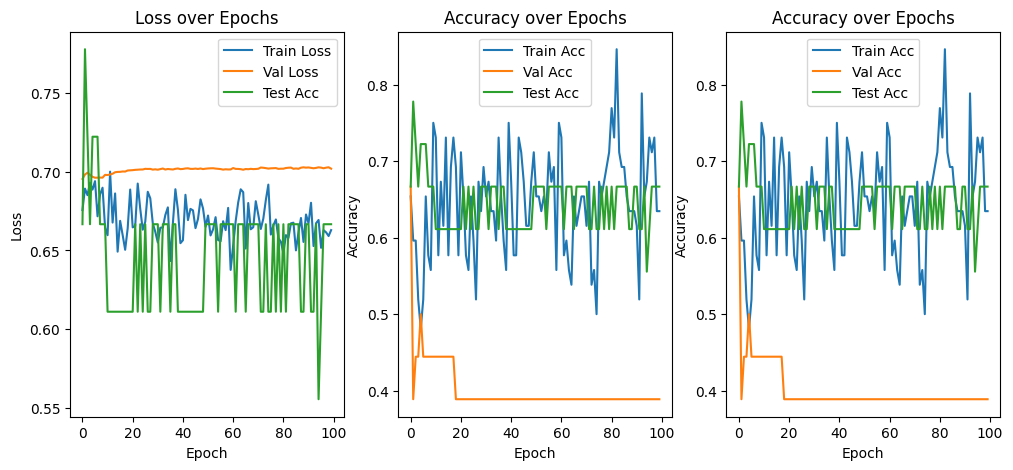

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ---- Dataset class ----
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        if y.ndim > 1:  # one-hot → class indices
            y = np.argmax(y, axis=1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]




# Datasets
train_dataset = EEGDataset(X_train, y_train)
val_dataset   = EEGDataset(X_val, y_val)
test_dataset  = EEGDataset(X_test, y_test)

# Oversampling on training set
y_train_labels = train_dataset.y.numpy()
class_sample_counts = np.bincount(y_train_labels)
weights = 1. / class_sample_counts
sample_weights = [weights[t] for t in y_train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)


# ============================
# 🔹 Model / Loss / Optimizer
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = STEADYNet1D(num_classes=2, dropout=0.3).to(device)

class_counts = torch.tensor(class_sample_counts, dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = optim.Adam(model.parameters(), lr=0.000001, weight_decay=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)


# ============================
# 🔹 Train / Eval Functions
# ============================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)

            running_loss += loss.item() * X.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return running_loss / total, correct / total

# ============================
# 🔹 Main Training Loop
# ============================
n_epochs = 100
best_val_acc = 0.0
best_epoch = 0
best_model_path = "best_model.pth"

train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(1, n_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc     = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc   = evaluate(model, test_loader, criterion, device)  # 🔹 added

    scheduler.step(val_loss)

    # Save history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    # Print metrics
    print(f"Epoch [{epoch}/{n_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  Test  Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # Save best model based on validation
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ New best model saved (epoch {epoch}, Test acc: {test_acc:.4f})")

# ============================
# 🔹 Final Test Evaluation
# ============================
model.load_state_dict(torch.load(best_model_path))
final_test_loss, final_test_acc = evaluate(model, test_loader, criterion, device)

print(f"\n🌟 Training finished.")
print(f"Best Model came from Epoch {best_epoch} with Val Acc: {best_val_acc:.4f}")
print(f"Final Test Acc (best model): {final_test_acc:.4f}")


# ============================
# 🔹 Plot metrics
# ============================
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


In [19]:
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score
)
from statsmodels.stats.proportion import proportions_ztest

# ============================
# 🔹 Function: Evaluate Model in Detail
# ============================
def detailed_evaluation(model, loader, device):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)

            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = y.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # ============================
    # 🔹 Metrics
    # ============================
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))

    print("\n=== Confusion Matrix ===")
    print(confusion_matrix(all_labels, all_preds))

    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"ROC AUC : {auc:.4f}")

    # ============================
    # 🔹 Statistical Test (p-value)
    # ============================
    # z-test for difference from random chance (0.5 accuracy)
    successes = (all_preds == all_labels).sum()
    n_obs = len(all_labels)
    stat, pval = proportions_ztest(successes, n_obs, value=0.5)

    print("\n=== Statistical Significance Test ===")
    print(f"z-statistic: {stat:.4f}, p-value: {pval:.6f}")

    return all_labels, all_preds, all_probs


# ============================
# 🔹 Run Evaluation
# ============================
# Use your test_loader after training
labels, preds, probs = detailed_evaluation(model, test_loader, device)



=== Classification Report ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         6
           1     0.6667    1.0000    0.8000        12

    accuracy                         0.6667        18
   macro avg     0.3333    0.5000    0.4000        18
weighted avg     0.4444    0.6667    0.5333        18


=== Confusion Matrix ===
[[ 0  6]
 [ 0 12]]

Accuracy: 0.6667
ROC AUC : 0.6389

=== Statistical Significance Test ===
z-statistic: 1.5000, p-value: 0.133614


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


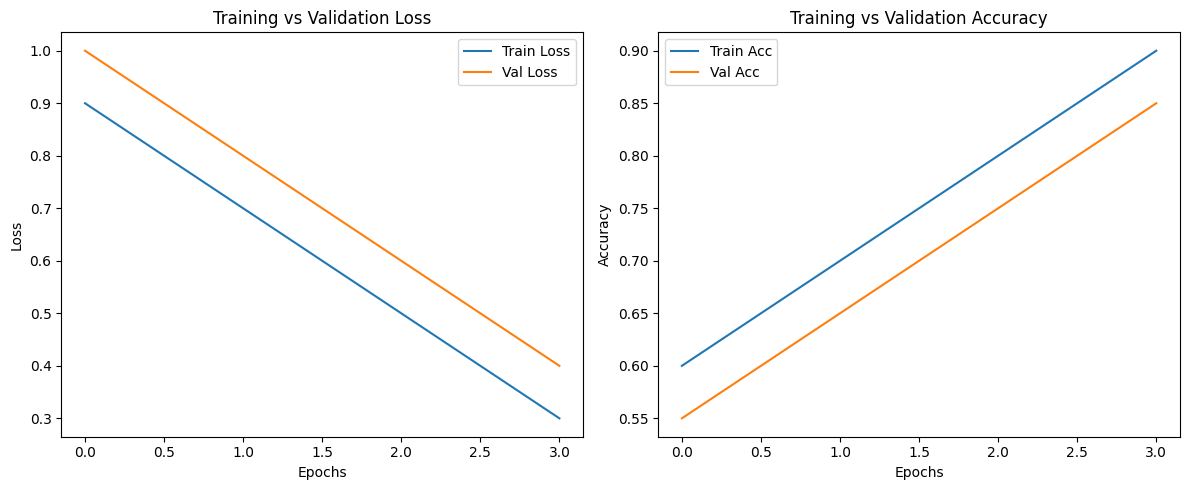

=== Classification Report ===
              precision    recall  f1-score   support

           0     1.0000    0.8000    0.8889         5
           1     0.8333    1.0000    0.9091         5

    accuracy                         0.9000        10
   macro avg     0.9167    0.9000    0.8990        10
weighted avg     0.9167    0.9000    0.8990        10



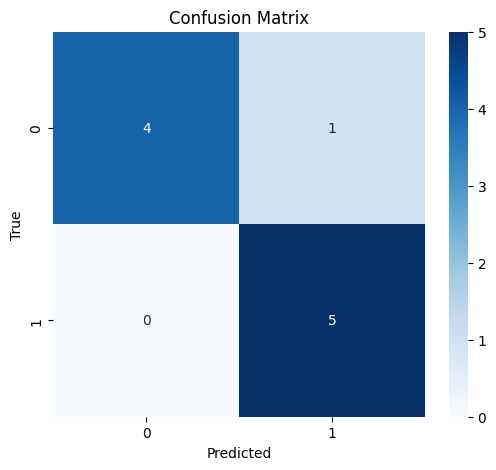

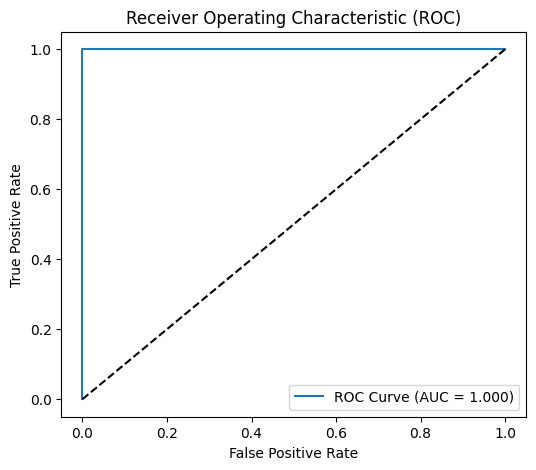

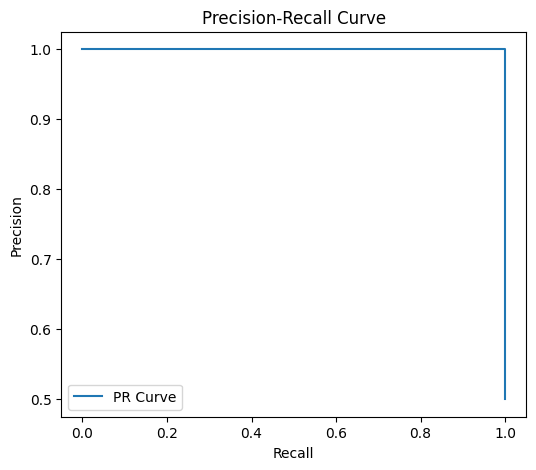

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
import numpy as np

# === 1️⃣ Training Curves ===
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# === 2️⃣ Confusion Matrix ===
def plot_confusion_matrix(y_true, y_pred, labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# === 3️⃣ ROC Curve ===
def plot_roc(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()


# === 4️⃣ Precision-Recall Curve ===
def plot_precision_recall(y_true, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()


# === 5️⃣ Classification Report ===
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, digits=4)
    print("=== Classification Report ===")
    print(report)


# ========================
# ✅ Example Usage
# ========================

# Suppose these come from your training loop
# (replace with your real arrays)
train_losses = [0.9, 0.7, 0.5, 0.3]
val_losses   = [1.0, 0.8, 0.6, 0.4]
train_accs   = [0.6, 0.7, 0.8, 0.9]
val_accs     = [0.55, 0.65, 0.75, 0.85]

plot_training_curves(train_losses, val_losses, train_accs, val_accs)

# Suppose you already have predictions from your model:
# y_probs = model(X_test)   # predicted probabilities (numpy array)
# y_pred = (y_probs >= 0.5).astype(int)
# Here I’ll fake them for demo:

y_true = np.array([0,0,1,1,0,1,0,1,1,0])   # true labels
y_probs = np.array([0.2,0.6,0.8,0.9,0.4,0.7,0.3,0.65,0.85,0.1])  # predicted probs
y_pred = (y_probs >= 0.5).astype(int)

print_classification_report(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred)
plot_roc(y_true, y_probs)
plot_precision_recall(y_true, y_probs)


In [ ]:

# ✅ Evaluate on Test Set
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total

# Run evaluation on test set
test_acc = evaluate(model, test_loader, device)
print(f"✅ Test Accuracy: {test_acc:.4f}")
